In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from novelty.models.dists import benford_dist, instrumental_dist
from novelty.models.mlp import MLP
from novelty.models.util import train_streaming_unbalanced, test, train_streaming, train_and_test_streaming
from novelty.visualization.models import plot_accs

/Users/akshay/opt/anaconda3/envs/novelty/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_labels_and_class_counts(labels_list):
    '''
    Calculates the counts of all unique classes.
    '''
    labels = np.array(labels_list)
    _, class_counts = np.unique(labels, return_counts=True)
    return labels, class_counts

class ImbalancedMNIST(Dataset):
    def __init__(self, imbal_class_prop, root, train, download, transform):
        self.dataset = datasets.MNIST(root, train=train, download=download, transform=transform)
        self.train = train
        self.imbal_class_prop = imbal_class_prop
        self.idxs = self.resample()

    def get_labels_and_class_counts(self):
        return self.labels, self.imbal_class_counts

    def resample(self, nb_classes = 10):
        '''
        Resample the indices to create an artificially imbalanced dataset.
        '''
        targets, class_counts = get_labels_and_class_counts(self.dataset.targets)
            
        # Get class indices for resampling
        class_indices = [np.where(targets == i)[0] for i in range(nb_classes)]
        # Reduce class count by proportion
        self.imbal_class_counts = [int(count * prop) for count, prop in zip(class_counts, self.imbal_class_prop)]
        # Get class indices for reduced class count
        idxs = []
        for c in range(nb_classes):
            imbal_class_count = self.imbal_class_counts[c]
            idxs.append(class_indices[c][:imbal_class_count])
        idxs = np.hstack(idxs)
        self.labels = targets[idxs]
        return idxs

    def __getitem__(self, index):
        img, target = self.dataset[self.idxs[index]]
        return img, target

    def __len__(self):
        return len(self.idxs)

In [3]:
device = 'cpu'
train_kwargs = {'batch_size': 1, 
               'shuffle': True}
test_kwargs = {'batch_size': 1000,
              'shuffle':True}
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # image mean and std 
    ])

In [4]:
reps = 10

# Imbalanced Training

In [5]:
#benford_dist(torch.arange(10))*(1/max(benford_dist(torch.arange(10))))
imbal_class_prop = torch.tensor(5*[0.1] + 5*[1.0])
train_dataset_imbalanced = ImbalancedMNIST(
    imbal_class_prop, 
    root='../data/raw', 
    train=True, 
    download=False,
    transform = transform
)
test_dataset_imbalanced = ImbalancedMNIST(
    imbal_class_prop, 
    root='../data/raw', 
    train=False, 
    download=False,
    transform = transform
)

In [6]:
train_loader_imbalanced = torch.utils.data.DataLoader(train_dataset_imbalanced,**train_kwargs)
test_loader_imbalanced = torch.utils.data.DataLoader(test_dataset_imbalanced, **test_kwargs)

In [7]:
examples_per_epoch = 5000
batches_per_epoch = examples_per_epoch//train_kwargs['batch_size']
epochs = len(train_loader_imbalanced.dataset)//examples_per_epoch

In [8]:
train_accs_imbalanced = []
test_accs_imbalanced = []
for restart in tqdm(range(reps)):
    model = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr = 0.01)
    train_acc, test_acc, kept_imbalanced = train_and_test_streaming(model, 
                                                                      optimizer, 
                                                                      train_loader_imbalanced, test_loader_imbalanced,
                                                                      epochs, batches_per_epoch)
    train_accs_imbalanced.append(train_acc)
    test_accs_imbalanced.append(test_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:14<00:00, 31.43s/it]


In [9]:
train_accs_imbalanced_tensor = torch.stack([torch.stack(accs) for accs in train_accs_imbalanced])
test_accs_imbalanced_tensor = torch.stack([torch.stack(accs) for accs in test_accs_imbalanced])

# Balanced Training with Same Number of Samples

In [25]:
#benford_dist(torch.arange(10))*(1/max(benford_dist(torch.arange(10))))
imbal_class_prop = torch.tensor(5*[0.1] + 5*[1.0])
train_dataset_balanced = datasets.MNIST(
    root='../data/raw', 
    train=True, 
    download=False,
    transform = transform
)
test_dataset_balanced = datasets.MNIST(
    root='../data/raw', 
    train=False, 
    download=False,
    transform = transform
)

In [26]:
train_loader_balanced = torch.utils.data.DataLoader(train_dataset_balanced,**train_kwargs)
test_loader_balanced = torch.utils.data.DataLoader(test_dataset_balanced, **test_kwargs)

In [27]:
examples_per_epoch = 5000
batches_per_epoch = examples_per_epoch//train_kwargs['batch_size']
epochs = len(train_loader_imbalanced.dataset)//examples_per_epoch

In [28]:
train_accs_balanced = []
test_accs_balanced = []
for restart in tqdm(range(reps)):
    model = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr = 0.01)
    train_acc, test_acc, kept_balanced = train_and_test_streaming(model, 
                                                                  optimizer, 
                                                                  train_loader_balanced, test_loader_balanced,
                                                                  epochs, batches_per_epoch)
    train_accs_balanced.append(train_acc)
    test_accs_balanced.append(test_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:35<00:00, 33.59s/it]


In [29]:
train_accs_balanced_tensor = torch.stack([torch.stack(accs) for accs in train_accs_balanced])
test_accs_balanced_tensor = torch.stack([torch.stack(accs) for accs in test_accs_balanced])

# Weighted Resampling

In [15]:
train_targets, train_class_counts = train_dataset_imbalanced.get_labels_and_class_counts()
weights = 1. / torch.tensor(train_class_counts, dtype=torch.float)
samples_weights = weights[train_targets]
for name, count, weight in zip(list(range(10)), train_class_counts, weights):
    print('Class {}: {} samples, {:.5} weight'.format(name, count, weight))

Class 0: 592 samples, 0.0016892 weight
Class 1: 674 samples, 0.0014837 weight
Class 2: 595 samples, 0.0016807 weight
Class 3: 613 samples, 0.0016313 weight
Class 4: 584 samples, 0.0017123 weight
Class 5: 5421 samples, 0.00018447 weight
Class 6: 5918 samples, 0.00016898 weight
Class 7: 6265 samples, 0.00015962 weight
Class 8: 5851 samples, 0.00017091 weight
Class 9: 5949 samples, 0.0001681 weight


In [16]:
from torch.utils.data.sampler import WeightedRandomSampler

sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True)

In [17]:
train_kwargs = {'batch_size': 1, 
               'shuffle': False,
               'sampler': sampler}

In [18]:
train_loader_weighted = torch.utils.data.DataLoader(train_dataset_imbalanced,**train_kwargs)

In [19]:
train_accs_reweighted = []
test_accs_reweighted = []
for restart in tqdm(range(reps)):
    model = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr = 0.01)
    train_acc, test_acc, kept_balanced = train_and_test_streaming(model, 
                                                                  optimizer, 
                                                                  train_loader_weighted, test_loader_imbalanced,
                                                                  epochs, batches_per_epoch)
    train_accs_reweighted.append(train_acc)
    test_accs_reweighted.append(test_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:14<00:00, 31.46s/it]


In [20]:
train_accs_reweighted_tensor = torch.stack([torch.stack(accs) for accs in train_accs_reweighted])
test_accs_reweighted_tensor = torch.stack([torch.stack(accs) for accs in test_accs_reweighted])

# With Adjusted Step Sizes

In [21]:
r = 0.1
step_sizes = 5*[0.02/(r+1)] + 5*[r*0.02/(r+1)]

In [22]:
train_accs_restepped = []
test_accs_restepped = []
for restart in tqdm(range(reps)):
    model = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr = 0.01)
    train_acc, test_acc, kept_balanced = train_and_test_streaming(model, 
                                                                  optimizer, 
                                                                  train_loader_imbalanced, test_loader_imbalanced,
                                                                  epochs, batches_per_epoch, 
                                                                  step_sizes = step_sizes)
    train_accs_restepped.append(train_acc)
    test_accs_restepped.append(test_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:18<00:00, 31.90s/it]


In [23]:
train_accs_restepped_tensor = torch.stack([torch.stack(accs) for accs in train_accs_restepped])
test_accs_restepped_tensor = torch.stack([torch.stack(accs) for accs in test_accs_restepped])

In [30]:
train_accs_all = torch.stack([train_accs_balanced_tensor,
                        train_accs_imbalanced_tensor,
                        train_accs_reweighted_tensor,
                        train_accs_restepped_tensor])

In [31]:
test_accs_all = torch.stack([test_accs_balanced_tensor,
                        test_accs_imbalanced_tensor,
                        test_accs_reweighted_tensor,
                        test_accs_restepped_tensor])

In [33]:
torch.save(torch.stack([train_accs_all,test_accs_all]), '../data/processed/results.pt')

In [34]:
train_results = pd.DataFrame(test_accs_all[:,:,-1,:].mean(axis=-1).T,
                             columns=['balanced','imbalanced','resampled','smart steps'])
results_melted = train_results.melt(var_name='method',value_name='accuracy')

(0.7, 1.0)

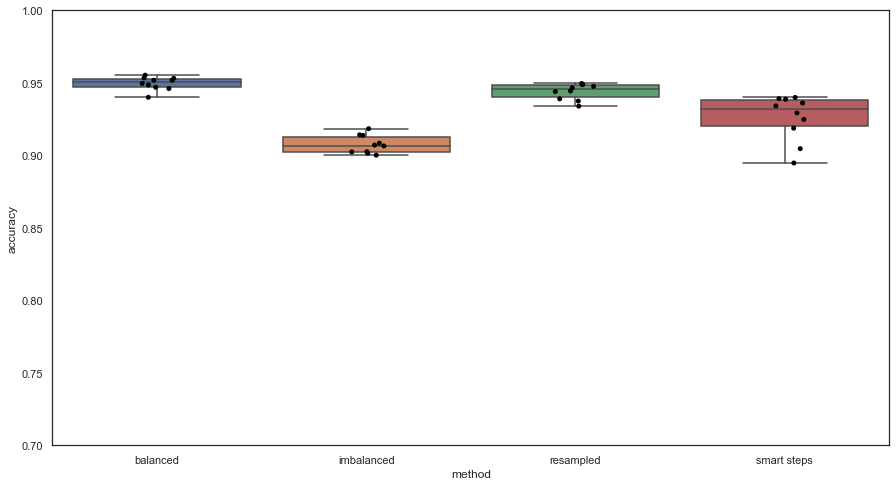

In [44]:
sns.boxplot(x = "method",
            y = "accuracy",
            data = results_melted)
sns.stripplot(x = "method",
              y = "accuracy",
              color = 'black',
              data = results_melted)
plt.ylim(0.7,1.0)

In [36]:
a,b,c,d = train_accs_all.shape
indices = torch.tensor([[[[(i,j,k,l) for l in range(d)] for k in range(c)] for j in range(b)] for i in range(a)]).flatten(0,3)
accs = train_accs_all.flatten()
flat_accs = torch.column_stack((indices, accs))

In [50]:
train_results = pd.DataFrame(flat_accs,
                             columns=['method','rep','epoch','digit','accuracy'])
train_results['method'] = train_results['method'].astype('category')
train_results['method'] = train_results['method'].cat.rename_categories({0.0:'balanced',
                                                                        1.0:'imbalanced',
                                                                        2.0:'resampled',
                                                                        3.0:'smart steps'})
train_results['digit'] = train_results['digit'].astype('int')

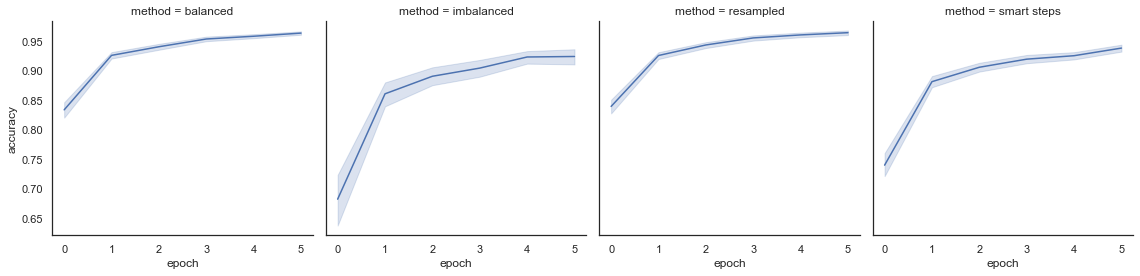

In [53]:
g = sns.FacetGrid(train_results, col="method",height=4,aspect=1)
g.map(sns.lineplot, "epoch","accuracy")

<AxesSubplot:xlabel='method', ylabel='accuracy'>

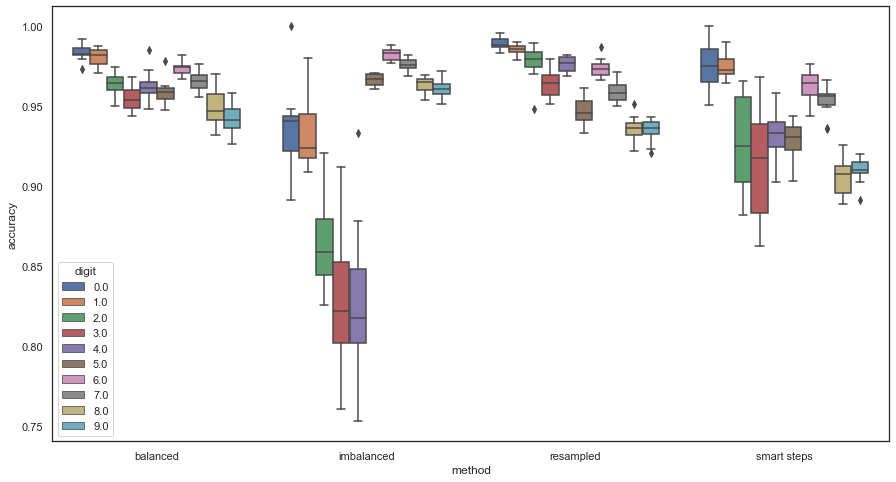

In [39]:
sns.set(rc = {'figure.figsize':(15,8)},
       style='white')
sns.boxplot(x = "method",
            y = "accuracy",
            hue = 'digit',
            data = train_results[train_results['epoch']==epochs-1])

<AxesSubplot:xlabel='method', ylabel='accuracy'>

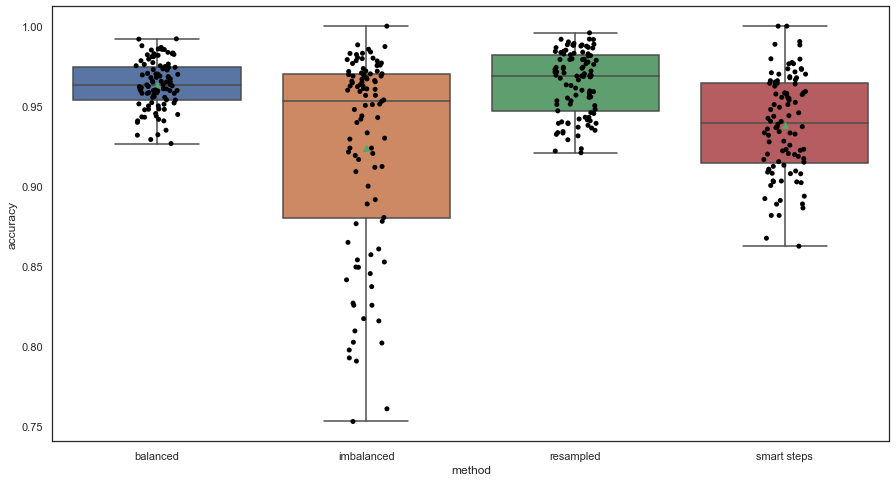

In [40]:
sns.set(rc = {'figure.figsize':(15,8)},
       style='white')
sns.boxplot(x = "method",
            y = "accuracy",
            data = train_results[train_results['epoch']==epochs-1], 
           showmeans=True)
sns.stripplot(x = "method",
              y = "accuracy",
              color = 'black',
              data = train_results[train_results['epoch']==epochs-1])